In this notebook, we download the data from the Biogen Solubiity Dataset, and do some unit coversions and exploratory data analysis. We also look at the impact of experimental error on the correlations we can achieve with a predictive model. 

In [8]:
import pandas as pd
from rdkit import Chem
import useful_rdkit_utils as uru
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

Grab the Biogen ADME data

In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/molecularinformatics/Computational-ADME/main/ADME_public_set_3521.csv")

Drop rows without solubility data

In [10]:
df = df.dropna(subset=["LOG SOLUBILITY PH 6.8 (ug/mL)"])

Grab the columns from the data table that we want

In [11]:
df = df[['Internal ID', 'Vendor ID', 'SMILES', 'CollectionName','LOG SOLUBILITY PH 6.8 (ug/mL)']]

Convert the data from log($\mu g$/ml) to log(moles/L)
$$
\frac{\mu M}{L}=\frac{\mu g}{ml} * \frac{1000 ml}{L} * \frac{1}{MW}
$$
First add a molecular weight column to the dataframe

In [12]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)
df['MW'] = df.mol.apply(uru.MolWt)

Convert solubility to $\mu g$/ml

In [13]:
df["SOLUBILITY PH 6.8 (ug/mL)"] = [10**x for x in df['LOG SOLUBILITY PH 6.8 (ug/mL)']]

Convert solubility to $\mu M$

In [14]:
df['SOLUBILITY (uM)'] = df["SOLUBILITY PH 6.8 (ug/mL)"]/df.MW*1000.0

Make sure the data makes sense. 

In [15]:
df['SOLUBILITY (uM)'].describe()

count    2173.000000
mean      109.148469
std        73.620051
min         0.213971
25%        45.032539
50%       120.017518
75%       158.978897
max       648.180101
Name: SOLUBILITY (uM), dtype: float64

Convert $\mu M$ solubility to LogS

In [16]:
df['logS'] = np.log10(df['SOLUBILITY (uM)']*1e-6)

Make sure the data still make sense

In [17]:
df.logS.describe()

count    2173.000000
mean       -4.236993
std         0.709761
min        -6.669644
25%        -4.346474
50%        -3.920755
75%        -3.798661
max        -3.188304
Name: logS, dtype: float64

Plot the LogS distribution

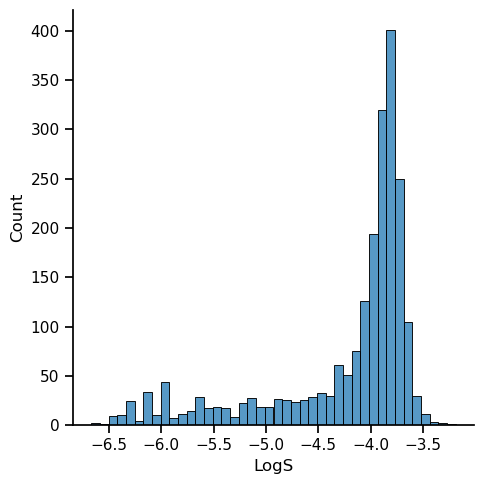

In [18]:
sns.set_context('notebook')
g = sns.displot(df.logS)
g.axes[0][0].set_xlabel("LogS");

In the figure above, we see that the data is skewed.  How many of the values are between -4 and -3.5?

In [19]:
len(df.query("logS >= -4 and logS <= -3.5"))/len(df)

0.5821445006902899

Just for fun, let's look at what the MAE would be if we guessed a single value for the predicted solubility. 

,Value,MAE
0,-6.5,2.263295
1,-6.0,1.783761
2,-5.5,1.359631
3,-5.0,0.984714
4,-4.5,0.670946
5,-4.0,0.460662
6,-3.5,0.737980


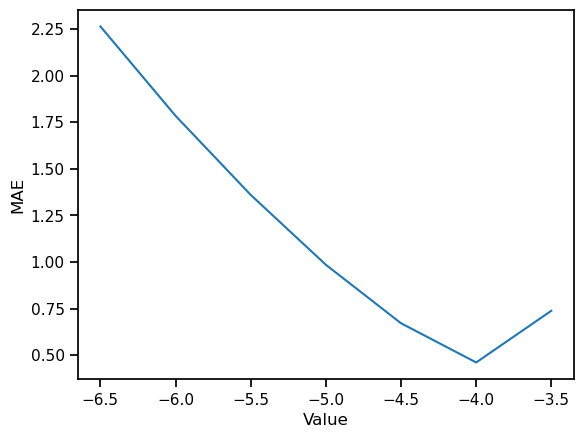

In [20]:
res = []
for i in np.arange(-6.5,-3.0,0.5):
    res.append([i,mean_absolute_error(df.logS,np.repeat(i,len(df)))])
res_df = pd.DataFrame(res,columns=["Value","MAE"])
sns.lineplot(x="Value",y="MAE",data=res_df)
res_df

Save the data for future analyses.

In [21]:
df[['Internal ID','Vendor ID','SMILES','logS']].to_csv("biogen_solubility.csv",index=False)

In [22]:
val_list = []
for i in [0.17,0.5,0.6]:
    for j in range(0,10000):
        val = np.random.choice(df.logS.values)
        err = np.random.normal(0,i)
        val_list.append([i,val,val+err])
val_df = pd.DataFrame(val_list,columns=["sd","val","err"])

In [24]:
label_list = []
for k,v in val_df.groupby("sd"):
    r = pearsonr(v.val,v.err).statistic
    label = f"r = {r:.02f}"
    label_list.append(label)

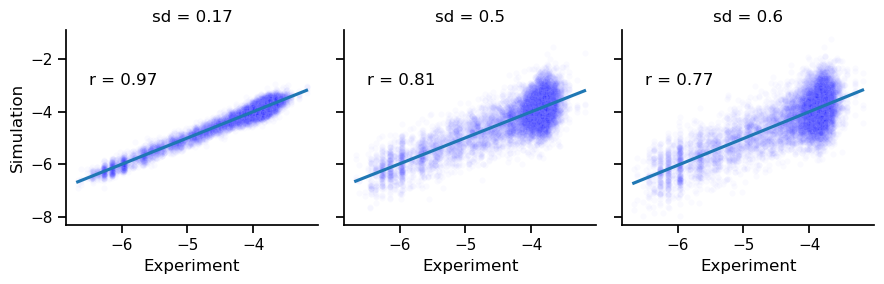

In [25]:
sns.set_context('notebook')
g = sns.lmplot(x="val",y="err",col="sd",data=val_df, height=3,
           scatter_kws=dict(alpha=0.02, s=20, color='blue', edgecolors='white'))
g.set_xlabels("Experiment")
g.set_ylabels("Simulation")
for ax,label in zip(g.axes[0],label_list):
    ax.text(-6.5, -3, label)